# Advanced Data Science Capstone

## Correlation of air pollution and Prevalence of Asthma bronchiale in Germany  

## Model definition: Gradient-Boosted Trees (GBTs) in SparkML

In [1]:
!ls ./
#Capstone.FeatureEng/

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190814083346-0001
KERNEL_ID = dba4046c-7b17-4399-8f69-5f7a38ec3901
Capstone.rawData  logs	spark-events  user-libs


### Data ETL and feature generation block for the current environment

In [2]:
# Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import collections
from io import StringIO
import os, fnmatch
import xml.etree.ElementTree as ET
from lxml import etree



total 0
Archive:  Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_O3_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM1_day.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM1_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM2_day.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_SO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_CO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_NO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_NO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_O3_hour.xml  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc250067e80>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

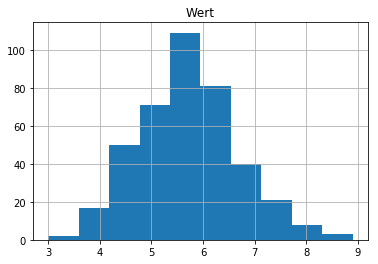

<Figure size 432x288 with 0 Axes>

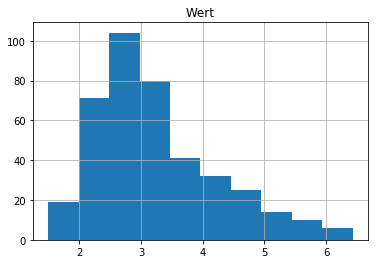

In [3]:
!rm -rf ./Capstone.rawData
## Download and decompress the dataset itself:
!mkdir Capstone.rawData
!ls -l Capstone.rawData/

##### Pollution 2016
!mkdir Capstone.rawData/AQD_DE_E1a_2016
urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2016.zip", "Capstone.rawData/AQD_DE_E1a_2016.zip")
!mv Capstone.rawData/AQD_DE_E1a_2016.zip Capstone.rawData/AQD_DE_E1a_2016/
!unzip Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip -d Capstone.rawData/
!rm Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip

##Download Sensor positions
urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2017.zip", "Capstone.rawData/AQD_DE_D_2017.zip")
!unzip Capstone.rawData/AQD_DE_D_2017.zip -d Capstone.rawData/
!rm Capstone.rawData/AQD_DE_D_2017.zip

## Download Town-county dataset:
urllib.request.urlretrieve("https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile",
                           "Capstone.rawData/GV100AD3107.zip")
!mkdir Capstone.rawData/GV100AD3107
!unzip Capstone.rawData/GV100AD3107.zip -d Capstone.rawData/GV100AD3107/
!rm Capstone.rawData/GV100AD3107.zip

!mkdir Capstone.rawData/Asthma_2016
urllib.request.urlretrieve("https://www.versorgungsatlas.de/fileadmin/excel/data_id_92_kreis11_1_j_1451606400.xlsx", "Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")

xlsx_file = pd.ExcelFile("Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfAsthma = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfAsthma.head(3))
print("Length of the dataset: ",len(dfAsthma))
plt.figure()
dfAsthma.hist(column='Wert')

!mkdir Capstone.rawData/Heart_2017
urllib.request.urlretrieve("https://www.versorgungsatlas.de/fileadmin/excel/data_id_97_kreis11_2_j_1483228800.xlsx", "Capstone.rawData/Heart_2017/data_id_97_kreis11_2_j_1483228800.xlsx")

xlsx_file = pd.ExcelFile("Capstone.rawData/Heart_2017/data_id_97_kreis11_2_j_1483228800.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfHeart = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfHeart.head(3))
print("Length of the dataset: ",len(dfHeart))
plt.figure()
dfHeart.hist(column='Wert')


In [4]:
def FetchXMLentryByWord(varName, NumToPrint):
    varFull = [s for s in AllTags if varName in s][NumToPrint]
    print(varFull)
    print([(varr.attrib, varr.text) for varr in Eroot.iter(varFull)][NumToPrint])
    print('\n')
def FetchAllXMLentriesByWord(varName):
    varFull = [s for s in AllTags if varName in s][0]
    print([(varr.attrib) for varr in Eroot.iter(varFull)])
    print('\n')
def FetchAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    print([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    print('\n')
def SelectAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    return([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 


In [5]:
AirE1aDir='Capstone.rawData/AQD_DE_E1a_2016/'

#!ls Capstone.rawData/AQD_DE_E1a_2017/*hour*
FilesHour=[]

for file in os.listdir(AirE1aDir):
    if fnmatch.fnmatch(file, '*hour*'):
        FilesHour.append(file)
print("Number of files in the dataset", len(FilesHour))

# shortening the process for debugging purposes
#FilesHour=FilesHour[0:3]        

dffAll=pd.DataFrame(index=range(0,8760))  # 8760 hours in the year

# add First column with Observation Times:
dff=[]  # Temporary list for DataFrames

file=FilesHour[0]
Etree = ET.parse(AirE1aDir+file)
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
varFull = [s for s in AllTags if 'values' in s][0]
for varr in Eroot.iter(varFull):
    dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))
dffAll=pd.concat([dffAll, dff[0][[0]]], axis=1)
dffAll.columns=['observation_period']


# get all tags in xml file; Note, that the actual data is kept as a TEXT of *values* tags 
for file in FilesHour:
    Etree = ET.parse(AirE1aDir+file)
    Eroot = Etree.getroot()
    Eroot.tag
    Eroot.attrib
    AllTags = [elem.tag for elem in Eroot.iter()]
    
    ColNamesExp=SelectAllXMLsensorID()
# Compare column names with file names, they should encode same country, state and pollutant
    for ColName in ColNamesExp:
        if ((ColName[0:2]!=file[0:2]) or (ColName[2:4]!=file[3:5]) or (ColName[8:11]!=file[11:14])):
            print("Inconsistency in file and column names: ", file, ColName)
            exit()
    
    varFull = [s for s in AllTags if 'values' in s][0]
    
    dff=[] # Temporary list for DataFrames
# reading actual pollutant data fiom the text field:    
    for varr in Eroot.iter(varFull):
        dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))

# checking, that measurment timestamps are identical in the files read       
    for s in range(0,len(dff)):
        if not (dffAll['observation_period']).equals(dff[s][0]):
            print("Inconsistency of observation times in the following files: ", file, FilesHour[0])
            exit()

        
# select column 4 - pollutant concentration:
    dff=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
    dff.columns=ColNamesExp
   
    dffAll=pd.concat([dffAll, dff], axis=1)

Number of files in the dataset 51


In [6]:
dffAll[dffAll.loc[:, dffAll.columns != 'observation_period'] < 0.0] = np.NaN
dffAll.interpolate(method='linear', inplace=True, axis=0, limit=876, limit_direction='both')
print('The number of corrupted columns is ', len(dffAll.isna().sum().nonzero()[0]), ' of ', len(dffAll.columns))
dffAll = dffAll.dropna(axis=1)
dffAll['observation_period']=pd.to_datetime(dffAll['observation_period'])
dffAll['observation_period']=dffAll['observation_period'].dt.to_period('H')
#dffAll['observation_period'][0].end_time
dffAll.tail(3)

/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  app.launch_new_instance()


The number of corrupted columns is  10  of  526


/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,observation_period,DESH008_NO2_dataGroup1,DESH022_NO2_dataGroup1,DESH023_NO2_dataGroup1,DESH025_NO2_dataGroup1,DESH027_NO2_dataGroup1,DESH028_NO2_dataGroup1,DESH030_NO2_dataGroup1,DESH033_NO2_dataGroup1,DESH035_NO2_dataGroup1,...,DEUB029_PM1_dataGroup1,DEUB030_PM1_dataGroup1,DEUB005_PM2_dataGroup1,DEUB001_SO2_dataGroup1,DEUB004_SO2_dataGroup1,DEUB005_SO2_dataGroup1,DEUB028_SO2_dataGroup1,DEUB029_SO2_dataGroup1,DEUB030_SO2_dataGroup1,DEUB046_SO2_dataGroup1
8781,2016-12-31 21:00,24.274,22.780,33.092,28.640,29.738,28.722,35.438,25.233,26.793,...,3.50,8.87,11.67,0.21,0.46,1.16,0.33,0.35,0.47,1.07
8782,2016-12-31 22:00,22.592,21.262,33.049,27.886,29.738,29.114,37.843,23.267,28.229,...,7.58,13.40,12.11,0.20,0.47,1.52,0.29,0.35,0.62,1.21
8783,2016-12-31 23:00,21.737,20.361,32.630,28.721,29.738,30.624,36.119,20.998,31.436,...,18.37,12.87,11.88,0.19,0.44,1.69,0.32,0.39,0.80,1.25


In [7]:
#!rm -rf ./Capstone.ETL
#!mkdir ./Capstone.ETL
#dffAll.to_csv('Capstone.ETL/Capstone.etl.wideCSV.1.0.gzip', compression='gzip', index=False)

In [8]:
# pick all tags from the XML file
Etree = etree.parse("Capstone.rawData/AQD_DE_D_2017/DE_D_allInOne_metaMeasurements_2017.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]

# get correct tag names for 'municipality', 'EUStationCode' and 'featureMember':
varMUN = [s for s in AllTags if 'municipality' in s][0]
varID  = [s for s in AllTags if 'EUStationCode' in s][0]
varFeatMem = [s for s in AllTags if 'featureMember' in s][0]

IDs=[]
MUNs=[]
# read 'municipality' and 'EUStationCode' to SensorLocation dataframe:
for varr in Eroot.iter(varFeatMem):
    for child in varr.iter(varMUN):
        MUNs.append(child.text)
        for child2 in varr.iter(varID):
            IDs.append(child2.text)
SensorLocation=pd.DataFrame({'SensorID': IDs, 'SensorTown': MUNs})
SensorLocation.tail(5)

,SensorID,SensorTown
803,DEUB005,Lüder
804,DEUB028,Zingst
805,DEUB029,Suhl
806,DEUB030,Stechlin
807,DEUB044,Garmisch-Partenkirchen


In [9]:
columns = [(10, 15), (22, 71), (72, 121)]
dfCT = pd.read_fwf("Capstone.rawData/GV100AD3107/GV100AD_310719.ASC", 
                     colspecs=columns, names=['countyid','town','county'],
                     encoding="iso8859_1")
dfCT=dfCT.fillna(method='ffill')

dfCT['town'] = dfCT['town'].str.split(",").str[0]
dfCT.tail(5)

,countyid,town,county
16116,16077,Starkenberg,Schmölln/Thür.
16117,16077,Thonhausen,Schmölln/Thür.
16118,16077,Treben,Schmölln/Thür.
16119,16077,Vollmershain,Schmölln/Thür.
16120,16077,Windischleuba,Schmölln/Thür.


In [10]:
xlsx_file = pd.ExcelFile("Capstone.rawData/Heart_2017/data_id_97_kreis11_2_j_1483228800.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfHeart = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfHeart.head(3))
print("Number of duplicates in Regions-ID column: ", dfHeart.duplicated(['Regions-ID']).sum())

xls sheet names:  ['Hintergrundinformationen', 'Daten']
             Region  Regions-ID  KV           Kreistyp  Wert  Bundeswert
0            Lk.Hof        9475  BY  Ländliches Umland  6.43        3.11
1  Mansfeld-Südharz       15087  ST    Ländlicher Raum  6.37        3.11
2               Hof        9464  BY  Ländliches Umland  6.36        3.11
Number of duplicates in Regions-ID column:  0


In [11]:
SensorLocation = (SensorLocation.join(dfCT[['countyid','town']].set_index('town'),
                                      on='SensorTown')).drop_duplicates(subset=['SensorID'])
SensorLocation=SensorLocation.dropna()
SensorLocation=SensorLocation.astype({'countyid':int})
SensorLocation.head(5)

,SensorID,SensorTown,countyid
0,DEBB007,Elsterwerda,12062
1,DEBB021,Potsdam,12054
2,DEBB026,Spremberg,12071
3,DEBB029,Schwedt/Oder,12073
4,DEBB032,Eisenhüttenstadt,12067


In [12]:
xlsx_file = pd.ExcelFile("Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfAsthma = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfAsthma.head(3))
print("Number of duplicates in Regions-ID column: ", dfAsthma.duplicated(['Regions-ID']).sum())
#dfAsthma.to_csv('Capstone.ETL/Capstone.etl.dfAsthmaCSV.1.0.csv', index=False)

xls sheet names:  ['Hintergrundinformationen', 'Daten']
      Region  Regions-ID  KV             Kreistyp  Wert  Bundeswert
0   Eisenach       16056  TH    Ländliches Umland   8.9         5.7
1  Sonneberg       16072  TH      Ländlicher Raum   8.7         5.7
2  Ammerland        3451  NI  Verdichtetes Umland   8.5         5.7
Number of duplicates in Regions-ID column:  0


In [13]:
# Files:
#SensorLocation = pd.read_csv('Capstone.ETL/Capstone.etl.SensorLocationCSV.1.0.csv')
#dfHeart = pd.read_csv('Capstone.ETL/Capstone.etl.dfHeartCSV.1.0.csv')
#dfAsthma = pd.read_csv('Capstone.ETL/Capstone.etl.dfAsthmaCSV.1.0.csv')
#dffAll = pd.read_csv('Capstone.ETL/Capstone.etl.wideCSV.1.0.gzip', compression='gzip', index_col=None)

dfDisease = dfAsthma

#### Mean pollutant concentration over the year
The quantity can be straightforward extracted using *.describe()* method of the data frame:

In [14]:
dffAllSummary=dffAll.describe()

def MeanByPollutantCountyID(Pollutant, CountyID):
    PollutantMasc='^.{8}' + Pollutant + '_'
# collecting set of all sensors in the given county:    
    CountyStationSet = SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist()
    if (CountyStationSet == []) or ([col for col in dffAllSummary.columns if re.search('(^.{7})',col).group(1) in CountyStationSet if ('_'+Pollutant+'_') in col] == []):
        return(np.nan)
    try:
        dffAllPollutantCountyID = dffAllSummary[[col for col in dffAllSummary.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)
        return(dffAllPollutantCountyID.loc[['mean']].mean(axis=1)[0])
    except:    
        return(np.nan)

In [15]:
ListOfPollutants = ['CO','NO','NO2','NOx','O3','PM1','PM2', 'PM10', 'SO2', 'CHB', 'CH4', 'C8H10', 'CHT', 'CO2']

for pollutant in ListOfPollutants:
    ColIndex=pollutant+'mean'
    dfDisease[ColIndex] =dfDisease.apply(lambda x: MeanByPollutantCountyID(pollutant, x['Regions-ID']), axis=1)
    
#dfDisease.head(53)
dfDisease.isna().sum()    

Region          0
Regions-ID      0
KV              0
Kreistyp        0
Wert            0
Bundeswert      0
COmean        391
NOmean        348
NO2mean       348
NOxmean       350
O3mean        350
PM1mean       352
PM2mean       383
PM10mean      402
SO2mean       373
CHBmean       391
CH4mean       402
C8H10mean     402
CHTmean       391
CO2mean       402
dtype: int64

From the table above one can see, that only 5 pollutants (*NO, NO2, NOx, O3, PM1*) were measured in about a half of German counties (total number of counties mentioned in the *heart failures* and *asthma bronchiale* datasets is 402). Let's take a look, in how many counties all 6 pollutants were measured simultaneously:

In [16]:
FeatureSetDenseMean = dfDisease[['Regions-ID','Wert','NOmean','NO2mean','NOxmean','O3mean','PM1mean']].dropna().reset_index(drop=True)
FeatureSetDenseMean.columns=['CountyID','DiseaseR','NOmean','NO2mean','NOxmean','O3mean','PM1mean']

In [17]:
#FeatureSetDenseMean.tail(55)
FeatureSetDenseMean.describe()
#FeatureSetDenseMean.isna().sum()
#FeatureSetDenseMean['NOmean'].mean()

,CountyID,DiseaseR,NOmean,NO2mean,NOxmean,O3mean,PM1mean
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,12808.853659,5.892683,10.915176,16.879199,32.991759,50.300838,15.403850
std,5116.970830,1.083834,12.508702,9.244565,28.075284,8.834913,3.595645
min,1002.000000,4.200000,0.163299,2.155348,2.637490,40.642753,7.460854
25%,14521.000000,5.200000,2.047583,9.932120,12.899541,44.599687,12.520184
50%,15003.000000,5.700000,6.803691,15.297707,25.471797,48.419621,15.508504
75%,16053.000000,6.700000,16.378347,21.588235,41.774936,52.279996,18.206161
max,16077.000000,8.700000,58.916103,41.784301,132.030190,83.072606,21.824518


In [18]:
FeatureSetLongMean = dfDisease[['Regions-ID','Wert','NOmean','NO2mean','PM1mean']].dropna().reset_index(drop=True)
FeatureSetLongMean.columns=['CountyID','DiseaseR','NOmean','NO2mean','PM1mean']
FeatureSetLongMean.describe()

,CountyID,DiseaseR,NOmean,NO2mean,PM1mean
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,12407.571429,5.875510,12.369953,18.167614,15.935149
std,5314.798471,1.097066,12.653499,9.226942,3.599833
min,1001.000000,4.200000,0.163299,2.155348,7.460854
25%,12065.000000,5.000000,2.246570,11.887994,13.327512
50%,15001.000000,5.700000,7.809633,16.773922,16.167680
75%,16052.000000,6.700000,16.884384,23.017952,18.558537
max,16077.000000,8.700000,58.916103,41.784301,22.832089


In [19]:
#!rm -rf Capstone.FeatureEng
#!mkdir Capstone.FeatureEng
#FeatureSetDenseMean.to_csv('Capstone.FeatureEng/Capstone.feature_eng.DenseMean.1.0.csv', index=False)
#FeatureSetLongMean.to_csv('Capstone.FeatureEng/Capstone.feature_eng.LongMean.1.0.csv', index=False)

##### Quantile-based features

Constructing the global distribution of selected pollutant concentration over all counties of interest, one can find e.g. 75th quantile of this pollutant concentration distribution, and than count number of hours, when this concentration was exceeded in each county. This quantity is some generalization of the "number of days when the pollutant limit has been exceeded" quantity, because it tune itself to pollution levels available in the dataset.


In [20]:
# Function for Croppind of initial dffAll dataset to columns reflecting measurements 
# of pollutants in ListOfPollutants at counties in ListOfCountyIDs:
def CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    dffAllCrop=pd.DataFrame(dffAll['observation_period'])

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_' 
        dffAllCrop=dffAllCrop.join(dffAll[[col for col in dffAll.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1))
    return(dffAllCrop)

# Function for calculating Nth percentiles for pollutants in ListOfPollutants at counties in ListOfCountyIDs:
def ReturnNthPercentilePollutantsIDsTS(Percentile, ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    NthPercentile=pd.DataFrame()

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_'
        NthPercentile[Pollutant] = [(dffAll[[col for col in dffAll.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)).stack().reset_index(drop=True).quantile(Percentile/100.0)]
    return(NthPercentile)

# Function for calculating Feature matrix, containing average (over sensors) number of hours for each county, when pollutant concentration
# was exceeding Nth global percentiles for the pollutant at counties of interest (in ListOfCountyIDs):
def FeatureMatrixNthPercentile(Percentile, ListOfPollutants, ListOfCountyIDs):
    NthPercentile=ReturnNthPercentilePollutantsIDsTS(Percentile, ListOfPollutants, ListOfCountyIDs)
    dffAllCrop=CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs)

    FeatureMatrix=pd.DataFrame({'CountyID': dfDisease.loc[dfDisease['Regions-ID'].isin(ListOfCountyIDs)]['Regions-ID'], 'DiseaseR': dfDisease.loc[dfDisease['Regions-ID'].isin(ListOfCountyIDs)]['Wert']}).reset_index(drop=True)
    for Pollutant in ListOfPollutants:
        PollutantHoursExceed=[]
        PollutantMasc='^.{8}' + Pollutant + '_'
        for CountyID in ListOfCountyIDs:
            CountyStationSet=[]
            CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())

            dffPollutantCounty = dffAllCrop[[col for col in dffAllCrop.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)
            NumPollutantStationsAtCounty = dffPollutantCounty.shape[1]
            PollutantHoursExceed.append((dffPollutantCounty.stack().reset_index(drop=True)>NthPercentile[Pollutant][0]).reset_index(drop=True).sum()/NumPollutantStationsAtCounty)
        FeatureMatrix = FeatureMatrix.reset_index(drop=True).join(pd.DataFrame({Pollutant : PollutantHoursExceed}))        
    return(FeatureMatrix)

In [21]:
ListOfPollutantsDense = ['NO','NO2','NOx','O3','PM1']
ListOfCountyIDsDense = FeatureSetDenseMean['CountyID']
FeatureSetDensePerc50 = FeatureMatrixNthPercentile(50, ListOfPollutantsDense, ListOfCountyIDsDense)
FeatureSetDensePerc75 = FeatureMatrixNthPercentile(75, ListOfPollutantsDense, ListOfCountyIDsDense)

ListOfPollutantsLong = ['NO','NO2','PM1']
ListOfCountyIDsLong = FeatureSetLongMean['CountyID']
FeatureSetLongPerc50 = FeatureMatrixNthPercentile(50, ListOfPollutantsLong, ListOfCountyIDsLong)
FeatureSetLongPerc75 = FeatureMatrixNthPercentile(75, ListOfPollutantsLong, ListOfCountyIDsLong)

#FeatureSetDensePerc50.to_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc50.1.0.csv', index=False)
#FeatureSetDensePerc75.to_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc75.1.0.csv', index=False)
#FeatureSetLongPerc50.to_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc50.1.0.csv', index=False)
#FeatureSetLongPerc75.to_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc75.1.0.csv', index=False)

In [22]:
def DiseaseFeaturePercentile(FeatureSetDF, Percentile):
    DiseasePercentile = (FeatureSetDF['DiseaseR']).quantile(Percentile/100.0)
    dfFeatureOut = FeatureSetLongPerc75.copy(deep=True)
    dfFeatureOut['DiseaseR'] = ((dfFeatureOut['DiseaseR'])>DiseasePercentile)
    dfFeatureOut=dfFeatureOut.rename(columns = {'DiseaseR':'DiseaseRFeat'})
    return(dfFeatureOut)

dfPolMeanLongDisease50perc = DiseaseFeaturePercentile(FeatureSetLongMean, 50.0)
dfPolMeanLongDisease75perc = DiseaseFeaturePercentile(FeatureSetLongMean, 75.0)
dfPolMeanLongDisease95perc = DiseaseFeaturePercentile(FeatureSetLongMean, 95.0)

dfPolLongPerc75Disease50perc = DiseaseFeaturePercentile(FeatureSetLongPerc75, 50.0)
dfPolLongPerc75Disease75perc = DiseaseFeaturePercentile(FeatureSetLongPerc75, 75.0)
dfPolLongPerc75Disease95perc = DiseaseFeaturePercentile(FeatureSetLongPerc75, 95.0)


### Logistic Regression

In [23]:

#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


#FeatureSetDenseMean = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.DenseMean.1.0.csv', index_col=None)
#FeatureSetLongMean = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.LongMean.1.0.csv', index_col=None)

#FeatureSetDensePerc50 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc50.1.0.csv', index_col=None)
#FeatureSetDensePerc75 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.DensePerc75.1.0.csv', index_col=None)

#FeatureSetLongPerc50 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc50.1.0.csv', index_col=None)
#FeatureSetLongPerc75 = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.LongPerc75.1.0.csv', index_col=None)

In [24]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

#dfPolMeanLongDisease50perc = spark.read.format("csv").load('Capstone.FeatureEng/Capstone.feature_eng.PolMeanLongDisease50perc.1.0.csv')
#dfPolMeanLongDisease75perc = spark.read.format("csv").load('Capstone.FeatureEng/Capstone.feature_eng.PolMeanLongDisease75perc.1.0.csv')
#dfPolMeanLongDisease95perc = spark.read.format("csv").load('Capstone.FeatureEng/Capstone.feature_eng.PolMeanLongDisease95perc.1.0.csv')

#dfPolLongPerc75Disease50perc = spark.read.format("csv").load('Capstone.FeatureEng/Capstone.feature_eng.PolLongPerc75Disease50perc.1.0.csv')
#dfPolLongPerc75Disease75perc = spark.read.format("csv").load('Capstone.FeatureEng/Capstone.feature_eng.PolLongPerc75Disease75perc.1.0.csv')
#dfPolLongPerc75Disease95perc = spark.read.format("csv").load('Capstone.FeatureEng/Capstone.feature_eng.PolLongPerc75Disease95perc.1.0.csv')
#df = dfPolLongPerc75Disease75perc
#df.show()

dfPolMeanLongDisease50perc.DiseaseRFeat = dfPolMeanLongDisease50perc.DiseaseRFeat.astype(int)
dfPolMeanLongDisease75perc.DiseaseRFeat = dfPolMeanLongDisease75perc.DiseaseRFeat.astype(int)
dfPolMeanLongDisease95perc.DiseaseRFeat = dfPolMeanLongDisease95perc.DiseaseRFeat.astype(int)

dfPolLongPerc75Disease50perc.DiseaseRFeat = dfPolLongPerc75Disease50perc.DiseaseRFeat.astype(int)
dfPolLongPerc75Disease75perc.DiseaseRFeat = dfPolLongPerc75Disease75perc.DiseaseRFeat.astype(int)
dfPolLongPerc75Disease95perc.DiseaseRFeat = dfPolLongPerc75Disease95perc.DiseaseRFeat.astype(int)

In [25]:
FeatureSet = dfPolLongPerc75Disease75perc

df = spark.createDataFrame(FeatureSet)

df.createOrReplaceTempView("df")
spark.sql("SELECT * from df").show()

+--------+------------+------------------+------------------+------------------+
|CountyID|DiseaseRFeat|                NO|               NO2|               PM1|
+--------+------------+------------------+------------------+------------------+
|   16072|           1|              22.0|             123.0|             295.0|
|   16073|           1|            1313.0|            1136.0|            2703.0|
|    1001|           1|            5836.0|            4973.0|            2884.0|
|   16062|           1|            1325.0|            1724.0|            1870.0|
|   16054|           1|            2441.5|            1946.5|            1161.0|
|   10044|           1| 992.6666666666666|1517.6666666666667|2030.6666666666667|
|   16077|           1|            1210.0|            1463.0|            1706.0|
|    1051|           1|            2589.0|            2702.0|            2928.0|
|    3360|           1|              84.0|             252.0|             889.0|
|    7232|           1|     

In [26]:
splits = df.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test  = splits[1]

In [27]:
df_train.count()

39

In [28]:
df_test.count()

10

In [29]:
#poly = PolynomialFeatures(2)
#poly.fit_transform(X_train0)
#X_train_UpToSquares = poly.transform(X_train0)
#X_test_UpToSquares = poly.transform(X_test0)


In [30]:
from pyspark.ml.feature import StringIndexer


indexer = StringIndexer(inputCol="DiseaseRFeat", outputCol="label")
indexed = indexer.fit(df_train).transform(df_train)
indexed.show()
indexed.select('label').distinct().show()

+--------+------------+------------------+------------------+------------------+-----+
|CountyID|DiseaseRFeat|                NO|               NO2|               PM1|label|
+--------+------------+------------------+------------------+------------------+-----+
|    1001|           1|            5836.0|            4973.0|            2884.0|  1.0|
|    1002|           0| 4913.333333333333| 4875.666666666667|            3724.0|  0.0|
|    1003|           0|            2039.0|            2465.5|            1818.0|  0.0|
|    1051|           1|            2589.0|            2702.0|            2928.0|  1.0|
|    1057|           0|              83.0|             493.0|            1632.0|  0.0|
|    3360|           1|              84.0|             252.0|             889.0|  1.0|
|   10041|           0|2825.6666666666665|2989.3333333333335|2172.3333333333335|  0.0|
|   10044|           1| 992.6666666666666|1517.6666666666667|2030.6666666666667|  1.0|
|   12065|           0|              13.0| 

In [31]:
#from pyspark.ml.feature import OneHotEncoder, StringIndexer
#
#encoder = OneHotEncoder(inputCol="classIndex", outputCol="categoryVec")
#encoded = encoder.transform(indexed)
#encoded.show()

In [32]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=["NO", "NO2", "PM1"],
                                  outputCol="featuresOO")

# For your special case that has string instead of doubles you should cast them first.
# expr = [col(c).cast("Double").alias(c) 
#         for c in vectorAssembler.getInputCols()]

# df2 = df2.select(*expr)

#features_vectorized = vectorAssembler.transform(encoded)
features_vectorized = vectorAssembler.transform(indexed)

features_vectorized.show()

+--------+------------+------------------+------------------+------------------+-----+--------------------+
|CountyID|DiseaseRFeat|                NO|               NO2|               PM1|label|          featuresOO|
+--------+------------+------------------+------------------+------------------+-----+--------------------+
|    1001|           1|            5836.0|            4973.0|            2884.0|  1.0|[5836.0,4973.0,28...|
|    1002|           0| 4913.333333333333| 4875.666666666667|            3724.0|  0.0|[4913.33333333333...|
|    1003|           0|            2039.0|            2465.5|            1818.0|  0.0|[2039.0,2465.5,18...|
|    1051|           1|            2589.0|            2702.0|            2928.0|  1.0|[2589.0,2702.0,29...|
|    1057|           0|              83.0|             493.0|            1632.0|  0.0| [83.0,493.0,1632.0]|
|    3360|           1|              84.0|             252.0|             889.0|  1.0|  [84.0,252.0,889.0]|
|   10041|           0|2825.

In [33]:
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors

normalizer = Normalizer(inputCol="featuresOO", outputCol="features", p=1.0)
l1NormData = normalizer.transform(features_vectorized)
l1NormData.show()

+--------+------------+------------------+------------------+------------------+-----+--------------------+--------------------+
|CountyID|DiseaseRFeat|                NO|               NO2|               PM1|label|          featuresOO|            features|
+--------+------------+------------------+------------------+------------------+-----+--------------------+--------------------+
|    1001|           1|            5836.0|            4973.0|            2884.0|  1.0|[5836.0,4973.0,28...|[0.42620316950266...|
|    1002|           0| 4913.333333333333| 4875.666666666667|            3724.0|  0.0|[4913.33333333333...|[0.36360048348503...|
|    1003|           0|            2039.0|            2465.5|            1818.0|  0.0|[2039.0,2465.5,18...|[0.32249901146698...|
|    1051|           1|            2589.0|            2702.0|            2928.0|  1.0|[2589.0,2702.0,29...|[0.31500182503954...|
|    1057|           0|              83.0|             493.0|            1632.0|  0.0| [83.0,493.

In [35]:
from pyspark.ml.classification import GBTClassifier
classifier = GBTClassifier(maxIter=10)
classifier.setLabelCol('label')

GBTClassifier_4f0fa5ffa8c1839c61d7

In [37]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer, vectorAssembler, normalizer, classifier])

model = pipeline.fit(df_train)
#model.stages[3].summary.accuracy

In [41]:
prediction = model.transform(df_train)
prediction.show()

+--------+------------+------------------+------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|CountyID|DiseaseRFeat|                NO|               NO2|               PM1|label|          featuresOO|            features|       rawPrediction|         probability|prediction|
+--------+------------+------------------+------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    1001|           1|            5836.0|            4973.0|            2884.0|  1.0|[5836.0,4973.0,28...|[0.42620316950266...|[-1.3119069754203...|[0.06762143174728...|       1.0|
|    1002|           0| 4913.333333333333| 4875.666666666667|            3724.0|  0.0|[4913.33333333333...|[0.36360048348503...|[1.32590267922033...|[0.93412217565278...|       0.0|
|    1003|           0|            2039.0|            2465.5|            1818.0|  0.0|[203

In [42]:
prediction.printSchema()

root
 |-- CountyID: long (nullable = true)
 |-- DiseaseRFeat: long (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- PM1: double (nullable = true)
 |-- label: double (nullable = false)
 |-- featuresOO: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("DiseaseRFeat")
binEval.evaluate(prediction)

1.0

In [49]:
predictionTest = model.transform(df_test)
predictionTest.show()
binEval.evaluate(predictionTest)

+--------+------------+------+------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|CountyID|DiseaseRFeat|    NO|               NO2|               PM1|label|          featuresOO|            features|       rawPrediction|         probability|prediction|
+--------+------------+------+------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    1053|           0|5759.0|            4826.0|            4200.0|  0.0|[5759.0,4826.0,42...|[0.38951640175853...|[1.32590267922033...|[0.93412217565278...|       0.0|
|    1061|           0|6553.0|            5901.0|            2279.0|  0.0|[6553.0,5901.0,22...|[0.44478381863843...|[-1.3119069754203...|[0.06762143174728...|       1.0|
|    7232|           1| 635.5|            1092.5|            1808.0|  1.0|[635.5,1092.5,180...|[0.17972285067873...|[1.18366832938472...|[0.9143024085

0.8

## GBT Summary
The GBT in the default configuration gives 80% accuracy on the *dfPolLongPerc75Disease75perc* feature set (correlation between 75th percentile of high pollutant concentration and 75th percentile of Asthma Bronchiale prevalence)